# Beijing Air Quality Forecasting Starter Notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')
print(train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

Here below we have :

* info() tells us datatypes (important for datetime).

* describe() highlights skew, scale differences, and potential need for transformations.

* Missing value counts guide how we’ll handle NaNs.


In [4]:
# Quick overview of dataset
print("Training Data Overview:")
print(train.info())
print(train.describe().T)  # summary stats
print(train.isnull().sum())  # check missing values per column
train.head()


Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None
           count          mean          std       min          25%  \
No       30676.0  15338.500000  8855.542765  1.000000  7669.750000   
DEWP     30676.0     -0.029431     0.994087 -2.135153    -0.888034   
TEMP     30676.0     -0.062712     1.015193

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])



# Handle missing values


### Handling missing values for features

*   Linear interpolation was used because it keeps the continuity of weather patterns
*   Create indicator columns for missingness which is useful for LSTM



In [7]:
#train.fillna(train.mean(), inplace=True)
#test.fillna(test.mean(), inplace=True)

# Define feature columns (exclude target + non-features)
train_feature_cols = [c for c in train.columns if c not in ["No","datetime","pm2.5"]]
test_feature_cols = [c for c in test.columns if c not in ["No","datetime"]]

# Interpolate missing values (time-consistent), then fill edges
train[train_feature_cols] = train[train_feature_cols].interpolate(method="linear").ffill().bfill()
test[test_feature_cols] = test[test_feature_cols].interpolate(method="linear").ffill().bfill()

# Confirm no missing values remain
print("Train missing values:\n", train.isna().sum())
print("Test missing values:\n", test.isna().sum())


train.head(), test.head()

Train missing values:
 No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64
Test missing values:
 No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


(   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
 0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
 1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
 2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
 3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
 4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   
 
              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
 0 2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
 1 2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
 2 2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
 3 2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
 4 2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN  ,
       No      DEWP      TEMP      PRES       Iws        Is        Ir  \
 0  30677  1.190496  0.701029 -2.186052 -0.003982 -0.069353 -0.137667   
 1  30678  1.121211  0.619051 -2.186052  0.031811 -0.069353

### Handling missing values for Target (pm2.5)

*   Drop rows where pm2.5 is NaN during training.
*   Can impute in order for us to avoid biasness in training.


In [8]:
# Drop rows where target 'pm2.5' is missing
train = train.dropna(subset=["pm2.5"]).reset_index(drop=True)

# Check remaining missing values
train_missing_summary = train.isna().sum()
train.head(), train_missing_summary

(   No      DEWP      TEMP      PRES       Iws        Is        Ir  \
 0  25 -1.234456 -1.348408  0.345943 -0.441894 -0.069353 -0.137667   
 1  26 -1.165172 -1.348408  0.345943 -0.424097 -0.069353 -0.137667   
 2  27 -0.888034 -1.430386  0.443328 -0.406301 -0.069353 -0.137667   
 3  28 -0.610897 -1.430386  0.540712 -0.370508  1.245803 -0.137667   
 4  29 -0.610897 -1.430386  0.540712 -0.352712  2.560959 -0.137667   
 
              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
 0 2010-01-02 00:00:00 -0.690542  1.366085 -0.522096  129.0  
 1 2010-01-02 01:00:00 -0.690542  1.366085 -0.522096  148.0  
 2 2010-01-02 02:00:00 -0.690542  1.366085 -0.522096  159.0  
 3 2010-01-02 03:00:00 -0.690542  1.366085 -0.522096  181.0  
 4 2010-01-02 04:00:00 -0.690542  1.366085 -0.522096  138.0  ,
 No          0
 DEWP        0
 TEMP        0
 PRES        0
 Iws         0
 Is          0
 Ir          0
 datetime    0
 cbwd_NW     0
 cbwd_SE     0
 cbwd_cv     0
 pm2.5       0
 dtype: int64)

## Visualizations

Our Columns and their explanations are the following :

1. No

* Row index/identifier.

* Not useful as a feature for modeling.

2. DEWP (Dew Point Temperature)

* The temperature at which air becomes saturated with moisture (°C).

* Strongly linked with humidity and air pollution dispersion.

3. TEMP (Temperature)

* Ambient air temperature (°C).

* Influences chemical reactions and pollutant concentration.

4. PRES (Pressure)

* Atmospheric pressure (hPa).

* Impacts air density and pollutant trapping.

5. Iws (Cumulative Wind Speed)

* Likely cumulative or scaled wind speed (m/s).

* Higher wind usually disperses pollutants.

6. Is (Cumulative Hours of Snow)

* Indicates snow events.

* Snow reduces PM2.5 by cleaning particulates from the air.

7. Ir (Cumulative Hours of Rain)

* Indicates rain events.

* Rain “washes out” particulates and lowers PM2.5.

8. datetime

* Timestamp (hourly).

* Essential for sequencing, seasonality, and time-based features (hour, day, month).

9. cbwd_NW, cbwd_SE, cbwd_cv

* One-hot encoded categorical variables for combined wind direction (cbwd):

* NW: wind from Northwest

* SE: wind from Southeast

* cv: calm/variable wind

* Wind direction is crucial for understanding pollutant transport.

10. pm2.5

* Target variable: fine particulate matter concentration (µg/m³).




### Time-Series Trends (Line Plots)
This shows whether pollution is seasonal (e.g., higher in winter). LSTMs rely on patterns, so visualizing helps justify window length (SEQ_LEN=24).

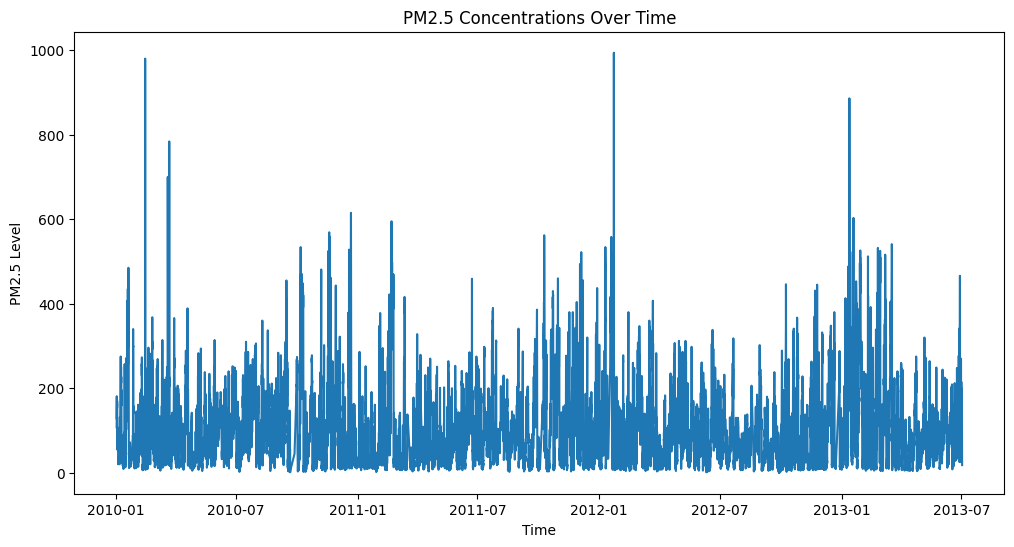

In [9]:
plt.figure(figsize=(12,6))
plt.plot(train['datetime'], train['pm2.5'])
plt.title("PM2.5 Concentrations Over Time")
plt.xlabel("Time")
plt.ylabel("PM2.5 Level")
plt.show()

### Histograms / Distributions


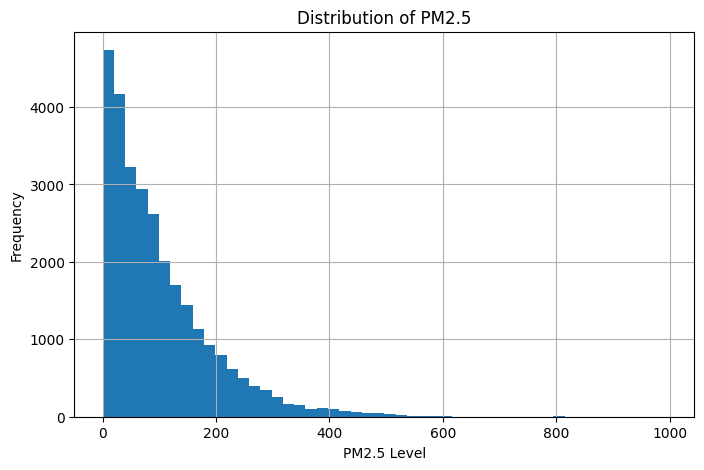

In [10]:
train['pm2.5'].hist(bins=50, figsize=(8,5))
plt.title("Distribution of PM2.5")
plt.xlabel("PM2.5 Level")
plt.ylabel("Frequency")
plt.show()

### Correlation Heatmap
This shows which features (e.g., temperature, dew point, wind speed) are most predictive. Helps with feature selection

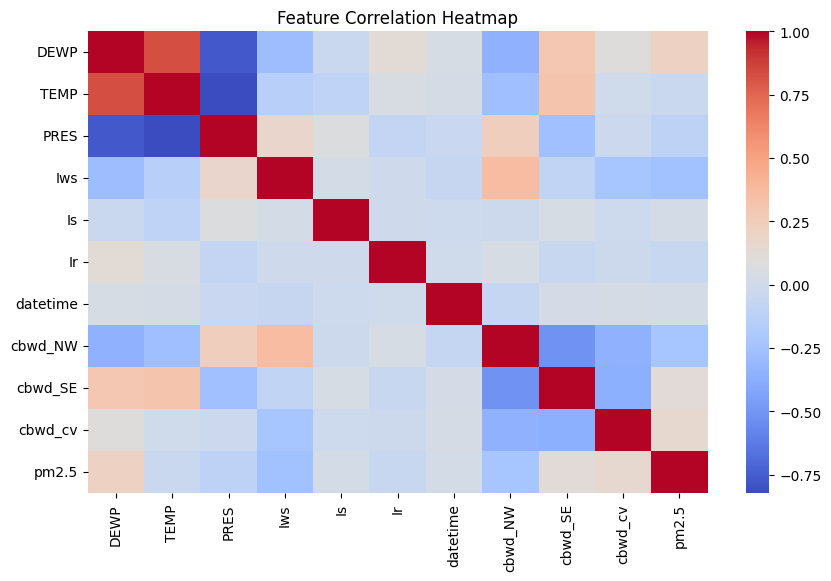

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(train.drop(['No'], axis=1).corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [12]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28755 entries, 0 to 28754
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        28755 non-null  int64         
 1   DEWP      28755 non-null  float64       
 2   TEMP      28755 non-null  float64       
 3   PRES      28755 non-null  float64       
 4   Iws       28755 non-null  float64       
 5   Is        28755 non-null  float64       
 6   Ir        28755 non-null  float64       
 7   datetime  28755 non-null  datetime64[ns]
 8   cbwd_NW   28755 non-null  float64       
 9   cbwd_SE   28755 non-null  float64       
 10  cbwd_cv   28755 non-null  float64       
 11  pm2.5     28755 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 2.6 MB


In [13]:
# 0. Select numeric feature columns
# ---------------------------------
train_feature_cols = [c for c in X_train.columns if X_train[c].dtype != "datetime64[ns]"]

# ---------------------------
# 1. Scaling
# ---------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train[train_feature_cols])

# ---------------------------
# 2. Sequence Creation
# ---------------------------
def make_sequences(X, y, seq_len=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])   # predict next step after seq_len
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24
X_seq, y_seq = make_sequences(X_scaled, y_train.values, seq_len=SEQ_LEN)

# Train/Validation split
split = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split], X_seq[split:]
y_train_t, y_val_t = y_seq[:split], y_seq[split:]

print("Train shape:", X_train_seq.shape, y_train_t.shape)
print("Val shape:", X_val_seq.shape, y_val_t.shape)

Train shape: (22984, 24, 9) (22984,)
Val shape: (5747, 24, 9) (5747,)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [14]:
# define model
model = Sequential([
    LSTM(128, activation="tanh", return_sequences=True, input_shape=(SEQ_LEN, X_scaled.shape[1])),
    Dropout(0.2),
    LSTM(64, activation="tanh"),
    Dropout(0.2),
    Dense(1)
])

# compile model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.005)
model.compile(optimizer=opt, loss='mse')

# Display the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
# ------------------ Callbacks ------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# ------------------ Training ------------------
history = model.fit(
    X_train_seq, y_train_t,
    validation_data=(X_val_seq, y_val_t),
    epochs=50,
    batch_size=64,
    callbacks=[es, rlr],
    shuffle=False
)

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - loss: 12254.2500 - val_loss: 13049.0186 - learning_rate: 0.0050
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - loss: 8059.4473 - val_loss: 11301.5293 - learning_rate: 0.0050
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - loss: 6420.9072 - val_loss: 9549.5439 - learning_rate: 0.0050
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - loss: 5807.4805 - val_loss: 9407.2305 - learning_rate: 0.0050
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step - loss: 5457.0737 - val_loss: 9860.9824 - learning_rate: 0.0050
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - loss: 5238.1582 - val_loss: 7830.3867 - learning_rate: 0.0050
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - loss: 4670.0879 - val_loss: 7435.3765 - learning_rate: 0.0050
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 44s 100ms/step - loss: 4392.3804 - val_loss: 7307.1396 - learning_rate: 0.0050
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/s

898/898 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step


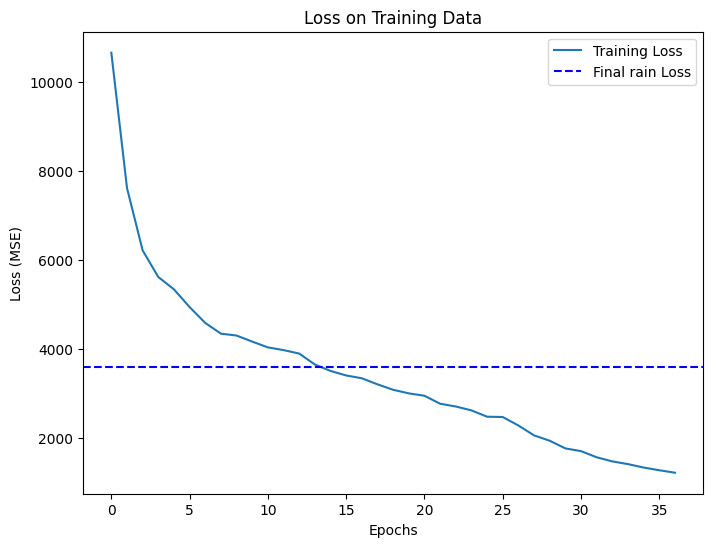

Final Training Loss (MSE): 3585.9796848306582


In [16]:
# Calculate training loss
train_predictions = model.predict(X_seq)
train_loss = np.mean((y_seq - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [ ]:
# Prepare the test data
X_test = test.drop(['No', 'datetime'], axis=1)   # also drop datetime

# Scale with training scaler
X_test_scaled = scaler.transform(X_test)

# Build sequences for test set (no target available, so pass dummy y)
X_test_seq, _ = make_sequences(X_test_scaled, np.zeros(len(X_test_scaled)), seq_len=SEQ_LEN)

# Convert predictions to integers
predictions = model.predict(X_test_seq)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index[SEQ_LEN:]).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

submission = submission.sort_values(by='row ID')

submission.to_csv('Datasets/submission.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step
